In [ ]:
IMAGE_PATH = "./cropped_receipt/cropped_image.png"

In [ ]:
!nvidia-smi

# OCR Space
### Pros:
- Simple implementation

### Cons:
- not accurate enough in OCR detection
- would require paid subscription as it scales due to OCR API

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
OCR_API_KEY=os.getenv("OCR_API_KEY")
OCR_SPACE_SAVE_JSON_PATH = "./outputs/OCR_Space_scanned_text.json"
OCR_SPACE_SAVE_IMG_PATH = "./outputs/OCR_Space_scanned_receipt.png"

In [ ]:
import requests
import json

payload = {
    'isOverlayRequired': True,
    'apikey': OCR_API_KEY,
    'language': "eng",
    "isTable": True,
    "scale": True,
}

with open(IMAGE_PATH, 'rb') as f:
    result = requests.post('https://api.ocr.space/parse/image', files={IMAGE_PATH: f}, data=payload).content.decode()

json_result = json.loads(result)

with open(OCR_SPACE_SAVE_JSON_PATH, 'w') as file:
    json.dump(json_result, file, indent=4)


In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from transformers import T5ForConditionalGeneration, AutoTokenizer

image = Image.open(IMAGE_PATH)
draw = ImageDraw.Draw(image)

path_to_model = "ai-forever/T5-large-spell"
model = T5ForConditionalGeneration.from_pretrained(path_to_model)
tokenizer = AutoTokenizer.from_pretrained(path_to_model)
prefix = "grammar: "

if "ParsedResults" in json_result:
    for parsed_text in json_result["ParsedResults"]:
        if "TextOverlay" in parsed_text:
            for line in parsed_text["TextOverlay"]["Lines"]:
                for word in line["Words"]:
                    box = [word["Left"], word["Top"], word["Left"] + word["Width"], word["Top"] + word["Height"]]
                    print(box)
                    text_position = (word["Left"], word["Top"] - 10)
                    
                    prompt = prefix + word["WordText"]
                    encodings = tokenizer(prompt, return_tensors="pt")
                    generated_tokens = model.generate(**encodings)
                    word = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
                    
                    draw.rectangle(box, outline="red", width=2)
                    draw.text(text_position, word, fill="red")

image.save(OCR_SPACE_SAVE_IMG_PATH)
plt.imshow(image)
plt.axis("off")
plt.show()


# EasyOCR

In [20]:
EASYOCR_SAVE_JSON_PATH = "./outputs/EasyOCR_scanned_text.json"
EASYOCR_SAVE_IMG_PATH = "./outputs/EasyOCR_scanned_receipt.png"

In [21]:
import easyocr

reader = easyocr.Reader(["en"])
results = reader.readtext(IMAGE_PATH)

RuntimeError: cuDNN error: CUDNN_STATUS_SUBLIBRARY_VERSION_MISMATCH

In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

image = Image.open(IMAGE_PATH)
draw = ImageDraw.Draw(image)

for result in results:
    # print(result)
    box = [result[0][0][0], result[0][0][1], result[0][2][0], result[0][2][1]]
    # print(box)
    text_position = (result[0][0][0], result[0][0][1] - 10)
    word = result[1]
    
    draw.rectangle(box, outline="red", width=2)
    draw.text(text_position, word, fill="red")

image.save(EASYOCR_SAVE_IMG_PATH)
plt.imshow(image)
plt.axis("off")
plt.show()
  

# PaddleOCR

In [ ]:
pip install paddlepaddle-gpu==3.0.0b1 -i https://www.paddlepaddle.org.cn/packages/stable/cu123/

In [25]:
PADDLEOCR_SAVE_JSON_PATH = "./outputs/PaddleOCR_scanned_text.json"
PADDLEOCR_SAVE_IMG_PATH = "./outputs/PaddleOCR_scanned_receipt.png"

[2024/11/18 00:22:04] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/d4rkc10ud/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/d4rkc10ud/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_te

[2024/11/18 00:22:04] ppocr WARNING: The first GPU is used for inference by default, GPU ID: 0
[2024/11/18 00:22:05] ppocr WARNING: The first GPU is used for inference by default, GPU ID: 0
[2024/11/18 00:22:06] ppocr DEBUG: dt_boxes num : 78, elapsed : 0.10724353790283203
[2024/11/18 00:22:07] ppocr DEBUG: cls num  : 78, elapsed : 0.13043737411499023
[2024/11/18 00:22:07] ppocr DEBUG: rec_res num  : 78, elapsed : 0.19691896438598633


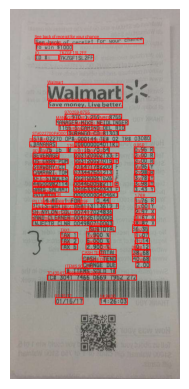

In [ ]:
from paddleocr import PaddleOCR
from PIL import Image
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

image = Image.open(IMAGE_PATH)
draw = ImageDraw.Draw(image)

ocr = PaddleOCR(use_angle_cls=True, lang='en')
results = ocr.ocr(IMAGE_PATH, cls=True)

# print(results)

for result in results[0]:
    box = [result[0][0][0], result[0][0][1], result[0][2][0], result[0][2][1]]
    text_position = (result[0][0][0], result[0][0][1] - 10)
    word = result[1][0]
    # print(result[1][0])
    
    draw.rectangle(box, outline="red", width=2)
    draw.text(text_position, word, fill="red")

image.save(PADDLEOCR_SAVE_IMG_PATH)
plt.imshow(image)
plt.axis("off")
plt.show()